In [1]:
#This notebook is where we want to save all our tests and comparisons. Please be sure to heavily comment your code!
#-------------------------------------------------------

#State Abbreviation/Names Dictionary
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}

#Replace STATE FIPS Codes with State names
fips_states = {2: 'Alaska',1: 'Alabama',3: 'American Samoa',5: 'Arkansas',4: 'Arizona',6: 'California',7: 'Canal Zone',8: 'Colorado',9: 'Connecticut',11: 'District of Columbia',10: 'Delaware',12: 'Florida',13: 'Georgia',14: 'Guam',15: 'Hawaii',19: 'Iowa',16: 'Idaho',17: 'Illinois',18: 'Indiana',20: 'Kansas',21: 'Kentucky',22: 'Louisiana',25: 'Massachusetts',24: 'Maryland',23: 'Maine',26: 'Michigan',27: 'Minnesota',29: 'Missouri',28: 'Mississippi',30: 'Montana',37: 'North Carolina',38: 'North Dakota',31: 'Nebraska',33: 'New Hampshire',34: 'New Jersey',35: 'New Mexico',32: 'Nevada',36: 'New York',39: 'Ohio',40: 'Oklahoma',41: 'Oregon',42: 'Pennsylvania',44: 'Rhode Island',43: 'Puerto Rico',45: 'South Carolina',46: 'South Dakota',47: 'Tennessee',48: 'Texas',49: 'Utah',51: 'Virginia',50: 'Vermont',53: 'Washington',55: 'Wisconsin',54: 'West Virginia',56: 'Wyoming'}

In [62]:
import pandas as pd
import sys
import os
from functools import reduce
import glob2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as plticker

In [63]:
#Let's begin by running some tests on our initial hypotheses. One cell per hypothesis, please!

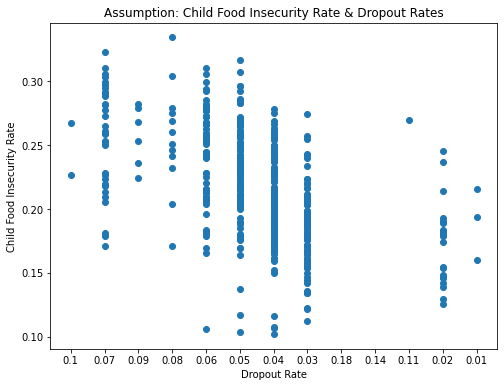

In [4]:
# ------> ASSUMPTION 1: Higher rates of food insecurity will result in higher rates of dropouts. <------

#Dropout Data
dropouts = pd.read_excel('/Users/kayh/Documents/DS4A/Working_Data/Teens ages 16 to 19 not in school and not high school graduates.xlsx')

#Cleaning dropout data: Rename headers, remove territories/nation rows, remove LocationType column
dropouts = dropouts.rename(columns = {'Location':'State','TimeFrame':'Year','Data':'Dropouts'})
drop_these = ['Territory','Nation']
dropouts = dropouts[~dropouts['LocationType'].isin(drop_these)]
dropouts = dropouts.drop('LocationType', axis=1).reset_index(drop=True)

#We want to keep the Number & Percent data but we need them to be each in their own column. I believe this requires a pivot?
dropouts = dropouts.pivot(index = ['State','Year'], columns = 'DataFormat', values='Dropouts')
dropouts = dropouts.rename(columns = {'Number':'# of Dropouts','Percent':'Dropout Percent'})

dropouts_original = dropouts.copy()
dropouts_c1 = dropouts_original.copy()

#Food Security Data
food_security = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Cleaned Datasets/cleaned_fa_data.csv')

#Cleaning food security data: Drop unnamed column, replace state abbreviations with names, subset for just the data we want, sort, aggregate, and ensure that dtypes are correct.
food_security = food_security.drop('Unnamed: 0', axis=1)
food_security = food_security.replace({'State': states})
food_security = food_security[['State','Year','Food Insecurity Rate','Number of Food Insecure Persons','Child food insecurity rate','Number of Food Insecure Children']]

#NOTE: This dataset was originally broken down by county. We want to aggregate the data appropriately. // The Child food insecurity rate column was an object dtype, had to change to numeric in order to agg.
food_security['Child food insecurity rate'] = pd.to_numeric(food_security['Child food insecurity rate'], errors='coerce')
food_security = food_security.groupby(['State','Year']).agg({'Food Insecurity Rate':'mean','Number of Food Insecure Persons':'mean','Child food insecurity rate':'mean','Number of Food Insecure Children':'sum'})

#Merge the two datasets
drop_food = pd.merge(dropouts_c1, food_security,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

#BEGIN TESTS HERE

#Is it helpful to compare the percentage rate distribution of each dataset? [[[[TEAM HELP! - CONSIDER THIS A BAT SIGNAL]]]]


plt.figure(figsize=(8,6))
x = drop_food['Dropout Percent']
y = drop_food['Child food insecurity rate']
plt.xlabel('Dropout Rate')
plt.ylabel('Child Food Insecurity Rate')
plt.title('Assumption: Child Food Insecurity Rate & Dropout Rates')
plt.scatter(x, y) 
plt.show()

Text(0.5, 1.0, 'Assumption: Guardian Educational Attainment & Dropouts')

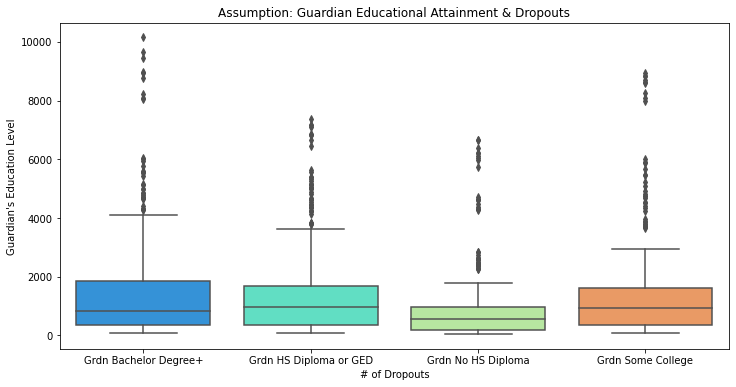

In [12]:
# ------> ASSUMPTION 2: A population with more guardians who have a higher level of educational attainment will have lower dropout rates. <------

#Use the "dropouts" dataset from above
dropouts_c2 = dropouts_original.copy()


#Educational Attainment Data
parent_edu = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Isolated_Metrics/parent_edu_attain.csv')

#Cleaning educational attainment data: Change state abbreviations to names, drop excess rows and NaN values, pivot, rename headers, drop totals.
parent_edu = parent_edu.replace({'State': states})
parent_edu = parent_edu.dropna()
parent_edu = parent_edu[~parent_edu['State'].str.contains('Total US')]
parent_edu = parent_edu[~parent_edu['Educational Attainment'].str.contains('Children under 15')]
parent_edu = pd.pivot_table(parent_edu, index = ['State','Year'], columns=['Educational Attainment'], values = ['Totals'])
parent_edu.columns = [' '.join(col).strip() for col in parent_edu.columns.values]
parent_edu = parent_edu.rename(columns = {'Totals Bachelor\'s degree or higher':'Grdn Bachelor Degree+','Totals High school or equivalent':'Grdn HS Diploma or GED', 'Totals No high school diploma':'Grdn No HS Diploma', 'Totals Some college, less than 4-yr degree':'Grdn Some College'})
parent_edu = parent_edu.drop('Totals Totals', axis=1)

#Merge the two datasets
drop_eduattain = pd.merge(dropouts_c2, parent_edu,  how='left', left_on=['State','Year'], right_on = ['State','Year'])
drop_eduattain['# of Dropouts'] = pd.to_numeric(drop_eduattain['# of Dropouts'], errors='coerce')
drop_eduattain_melt = drop_eduattain.melt(id_vars=['# of Dropouts','Dropout Percent'], value_vars=['Grdn Bachelor Degree+','Grdn HS Diploma or GED','Grdn No HS Diploma','Grdn Some College'],var_name='Edu Level', value_name='Edu Attainment')

drop_eduattain_melt['Edu Attainment'] = pd.to_numeric(drop_eduattain_melt['Edu Attainment'], errors='coerce')

#BEGIN TEST HERE

plt.figure(figsize=(12,6))
sns.boxplot(y='Edu Attainment',x='Edu Level',data=drop_eduattain_melt,palette='rainbow')
plt.xlabel('# of Dropouts')
plt.ylabel('Guardian\'s Education Level')
plt.title('Assumption: Guardian Educational Attainment & Dropouts')

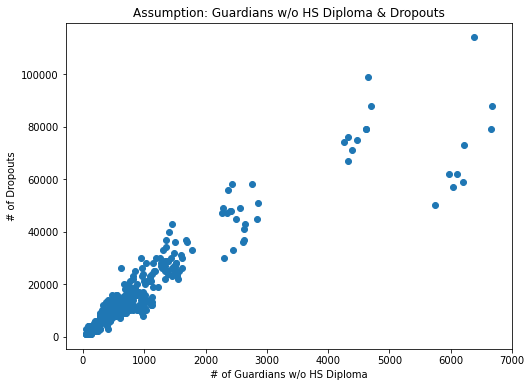

In [17]:
#Scatter Plot - Guardians w/o HS Diploma

plt.figure(figsize=(8,6))
y = drop_eduattain['# of Dropouts']
x = drop_eduattain['Grdn No HS Diploma']
plt.ylabel('# of Dropouts')
plt.xlabel('# of Guardians w/o HS Diploma')
plt.title('Assumption: Guardians w/o HS Diploma & Dropouts')
plt.scatter(x, y) 
plt.show()

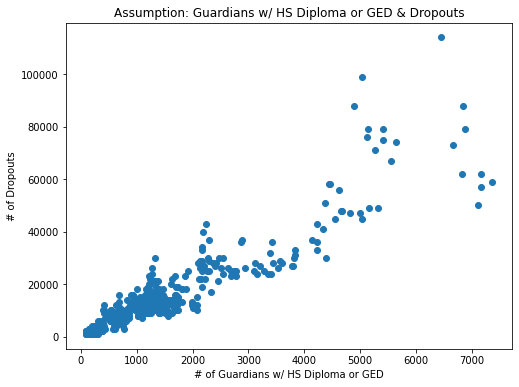

In [20]:
#Scatter Plot - Guardians w/ HS Diploma or GED

plt.figure(figsize=(8,6))
y = drop_eduattain['# of Dropouts']
x = drop_eduattain['Grdn HS Diploma or GED']
plt.ylabel('# of Dropouts')
plt.xlabel('# of Guardians w/ HS Diploma or GED')
plt.title('Assumption: Guardians w/ HS Diploma or GED & Dropouts')
plt.scatter(x, y) 
plt.show()


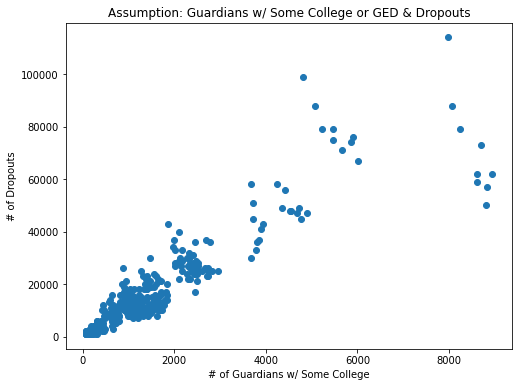

In [18]:
#Scatter Plot - Guardians w/ Some College

plt.figure(figsize=(8,6))
y = drop_eduattain['# of Dropouts']
x = drop_eduattain['Grdn Some College']
plt.ylabel('# of Dropouts')
plt.xlabel('# of Guardians w/ Some College')
plt.title('Assumption: Guardians w/ Some College or GED & Dropouts')
plt.scatter(x, y) 
plt.show()

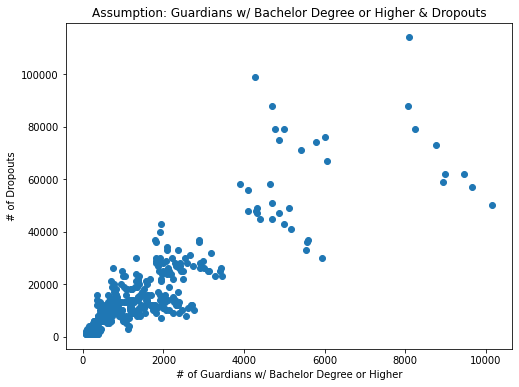

In [19]:
#Scatter Plot - Guardians w/ a Bachelor Degree or Higher

plt.figure(figsize=(8,6))
y = drop_eduattain['# of Dropouts']
x = drop_eduattain['Grdn Bachelor Degree+']
plt.ylabel('# of Dropouts')
plt.xlabel('# of Guardians w/ Bachelor Degree or Higher')
plt.title('Assumption: Guardians w/ Bachelor Degree or Higher & Dropouts')
plt.scatter(x, y) 
plt.show()

In [98]:
# ------> ASSUMPTIONS 3: Increased funding (federal and/or state) means dropout rates will be lower. <------

#Use the "dropouts" dataset from above
dropouts_c3 = dropouts_original.copy()

#State Funding Data
state_fund = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Isolated_Metrics/state_funding.csv')

#Federal Funding Data
fed_fund = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Isolated_Metrics/fed_funding.csv')

#Merge & Clean funding data: Drop unnamed rows, rename headers, drop excess rows (territories & non-primary states), convert State FIPS to state names, change year of data to YYYY format,
funding = pd.merge(state_fund, fed_fund,  how='left', left_on=['STATE', 'Year of Data'], right_on = ['STATE','Year of Data'])
funding = funding.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1)
funding = funding.rename(columns = {'STATE':'State','Year of Data':'Year','Total Revenue from Federal Sources':'Total Federal Revenue','Total Revenue from State Sources':'Total State Revenue'})
funding = funding.replace({'State': fips_states})
not_continental = ['American Samoa', 'Canal Zone', 'Guam', 'Puerto Rico']
funding = funding[~funding['State'].isin(['not_continental'])]
years = {9:2009, 10:2010, 11:2011, 12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 17:2017}
funding = funding.replace({'Year': years})

drop_fund = pd.merge(dropouts_c3, funding,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

drop_fund_federal = drop_fund.copy()
drop_fund_state = drop_fund.groupby(['State','Year']).agg({'Total State Revenue':'mean'})
drop_fund_state = drop_fund_state.reset_index()

#BEGIN TEST HERE

plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(drop_fund['# of Dropouts'] , color="dodgerblue", label="# of Dropouts")
sns.distplot(drop_fund['Total Federal Revenue'] , color="orange", label="Federal Funding")
sns.distplot(drop_fund['Total State Revenue'] , color="deeppink", label="State Funding")

plt.title('Funding & Dropouts')
plt.show()

ValueError: could not convert string to float: '<500'

In [ ]:

drop_fund = pd.merge(dropouts_c3, funding,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

In [74]:
# ------> ASSUMPTION 4: Higher rates of teen pregnancies likely mean higher dropout rates. <------

#Use the "dropouts" dataset from above
dropouts_c4 = dropouts_original.copy()

#Teen Pregnancy Data
teen_preg = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Final_Data_Code/teen_pregnancy.csv')

#Cleaning teen pregnancy data
teen_preg = teen_preg.groupby(['State','Year']).agg({'Teen Preg. Rate (State)':'mean','# Teen Births (State)':'mean','# Teen Births (US)':'mean','U.S. Birth Rate':'mean'})


#BEGIN TEST HERE

plt.figure(figsize=(8,6))
x = drop_employ['Dropout Percent']
y = drop_employ['% Employed']
plt.xlabel('# of Dropouts')
plt.ylabel('Employed per 1k')
plt.title('Correlation: Teen Employment & Dropout Rates')
plt.scatter(x, y) 
plt.show()

DataError: No numeric types to aggregate

In [73]:
teen_preg

NameError: name 'teen_preg' is not defined

In [ ]:
#Now that we've gone through these, based on the full data heatmap, we did discuss that there were some additional findings that we wanted to take a look at. 
#Please include that analysis below.

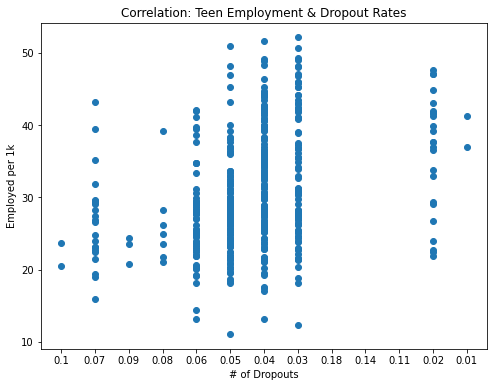

In [60]:
# ------> FINDING 1: Dropouts & Employed per 1k vs (Dropouts & Employed Rate) <------

#Use the "dropouts" dataset from above
dropouts_f1 = dropouts_original.copy()

#Student Employment Data
teen_employ = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Final_Data_Code/teen_employment.csv')
teen_employ = teen_employ.drop('Unnamed: 0', axis=1)

#Merge the two datasets
drop_employ = pd.merge(dropouts_f1, teen_employ,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

plt.figure(figsize=(8,6))
x = drop_employ['Dropout Percent']
y = drop_employ['% Employed']
plt.xlabel('# of Dropouts')
plt.ylabel('Employed per 1k')
plt.title('Correlation: Teen Employment & Dropout Rates')
plt.scatter(x, y) 
plt.show()

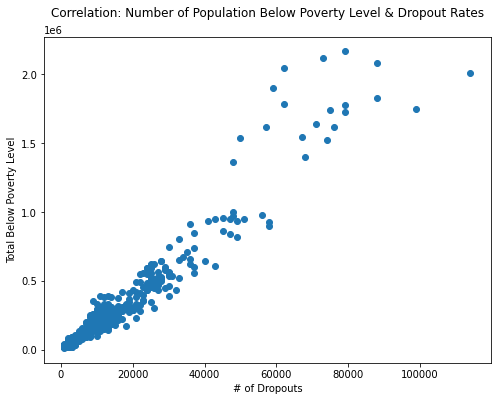

In [71]:
# ------> FINDING 2: Dropouts & Population Number below Poverty Level vs (Dropouts & Percent of Population below the poverty level) <------

#Use the "dropouts" dataset from above
dropouts_f2 = dropouts_original.copy()

#Poverty Data
poverty = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Final_Data_Code/childpoverty.csv')
poverty = poverty.drop('Unnamed: 0', axis=1).reset_index(drop=True)

#Merge the two datasets
drop_pov = pd.merge(dropouts_f2, poverty,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

drop_pov['# of Dropouts'] = pd.to_numeric(drop_pov['# of Dropouts'], errors='coerce')


#Number of Population Plot
plt.figure(figsize=(8,6))
x = drop_pov['# of Dropouts']
y = drop_pov['Total Below Poverty Level']
plt.xlabel('# of Dropouts')
plt.ylabel('Total Below Poverty Level')
plt.title('Correlation: Number of Population Below Poverty Level & Dropout Rates',pad=20)
plt.scatter(x, y) 
plt.show()

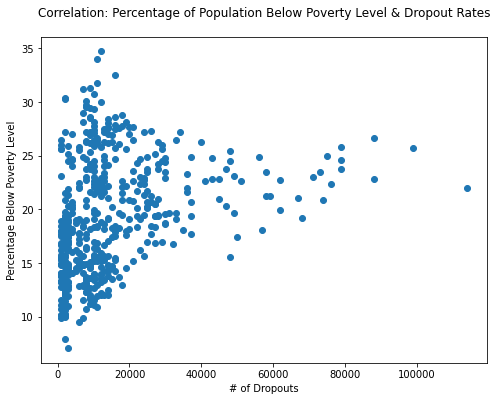

In [72]:
#Percent of Population Plot
plt.figure(figsize=(8,6))
x = drop_pov['# of Dropouts']
y = drop_pov['Percentage Below Poverty Level']
plt.xlabel('# of Dropouts')
plt.ylabel('Percentage Below Poverty Level')
plt.title('Correlation: Percentage of Population Below Poverty Level & Dropout Rates',pad=20)
plt.scatter(x, y) 
plt.show()

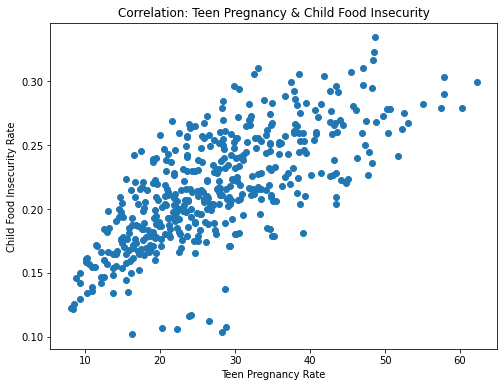

In [38]:
# ------> FINDING 3: Food Insecurity & Teen Pregnancy Rates <------

#Food Security Data
food_security = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Final_Data_Code/food_security.csv')
food_security = food_security.drop('Unnamed: 0', axis=1)

food_security['Food Insecurity Rate'] = pd.to_numeric(food_security['Food Insecurity Rate'], errors='coerce')
food_security['Child food insecurity rate'] = pd.to_numeric(food_security['Child food insecurity rate'], errors='coerce')

food_security = food_security.groupby(['State','Year']).agg({'Food Insecurity Rate':'mean','Child food insecurity rate':'mean'})

#Teen Pregnancy Data
teen_preg = pd.read_csv('/Users/kayh/Documents/DS4A/team_81_project/Final_Data_Code/teen_pregnancy.csv')

teen_preg['Teen Preg. Rate (State)'] = pd.to_numeric(teen_preg['Teen Preg. Rate (State)'], errors='coerce')
teen_preg['# Teen Births (State)'] = pd.to_numeric(teen_preg['# Teen Births (State)'], errors='coerce')
teen_preg['# Teen Births (US)'] = pd.to_numeric(teen_preg['# Teen Births (US)'], errors='coerce')
teen_preg['U.S. Birth Rate'] = pd.to_numeric(teen_preg['U.S. Birth Rate'], errors='coerce')

teen_preg = teen_preg.groupby(['State','Year']).agg({'Teen Preg. Rate (State)':'mean','# Teen Births (State)':'mean','# Teen Births (US)':'mean','U.S. Birth Rate':'mean'})

#Merge the two datasets
teen_food = pd.merge(teen_preg, food_security,  how='left', left_on=['State','Year'], right_on = ['State','Year'])

plt.figure(figsize=(8,6))
x = teen_food['Teen Preg. Rate (State)']
y = teen_food['Child food insecurity rate']
plt.xlabel('Teen Pregnancy Rate')
plt.ylabel('Child Food Insecurity Rate')
plt.title('Correlation: Teen Pregnancy & Child Food Insecurity')
plt.scatter(x, y) 
plt.show()